In [1]:
from src.load_balancer.simulation import simulation_cli
import numpy as np

In [2]:
sim = await simulation_cli(num_servers=2,server_buffer_size=2,server_mu=0.04,lambda_=50,simulation_time=3,routing_fn='shortest_queue')


00:00:040 | INFO | [WS2] ✅ Processed request   2 (0.01s)
00:00:047 | INFO | [WS2] ✅ Processed request   3 (0.01s)
00:00:080 | INFO | [WS1] ✅ Processed request   0 (0.07s)
00:00:089 | INFO | [WS1] ✅ Processed request   1 (0.01s)
00:00:090 | INFO | [WS2] ✅ Processed request   4 (0.01s)
00:00:107 | INFO | [WS1] ✅ Processed request   5 (0.02s)



Start symulacji - polityka route_shortest_queue


00:00:137 | INFO | [WS1] ✅ Processed request   6 (0.01s)
00:00:150 | INFO | [WS1] ✅ Processed request   7 (0.01s)
00:00:227 | INFO | [WS1] ✅ Processed request   8 (0.06s)
00:00:263 | INFO | [WS2] ✅ Processed request  10 (0.04s)
00:00:339 | INFO | [WS2] ✅ Processed request  12 (0.05s)
00:00:359 | INFO | [WS1] ✅ Processed request   9 (0.13s)
00:00:383 | INFO | [WS2] ✅ Processed request  13 (0.04s)
00:00:399 | INFO | [WS2] ✅ Processed request  15 (0.02s)
00:00:421 | INFO | [WS2] ✅ Processed request  16 (0.02s)
00:00:469 | INFO | [WS1] ✅ Processed request  11 (0.11s)
00:00:475 | INFO | [WS1] ✅ Processed request  14 (0.01s)
00:00:477 | INFO | [WS2] ✅ Processed request  17 (0.06s)
00:00:515 | INFO | [WS1] ✅ Processed request  18 (0.04s)
00:00:547 | INFO | [WS1] ✅ Processed request  21 (0.03s)
00:00:548 | INFO | [WS1] ✅ Processed request  22 (0.00s)
00:00:554 | INFO | [WS2] ✅ Processed request  19 (0.08s)
00:00:580 | INFO | [WS1] ✅ Processed request  24 (0.03s)
00:00:617 | INFO | [WS1] ❌ Reje


Polityka: route_shortest_queue
Przetworzone zgłoszenia: 116
Odrzucone zgłoszenia: 18
Zgłoszenia w kolejkach: 2


In [3]:
import json
import pandas as pd

def process_queue_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
    
    data_df = pd.DataFrame(data)
    
    def convert_to_ms(timestamp):
        m, s, ms = timestamp.split(':')
        total_ms = (int(m) * 60 * 1000) + (int(s) * 1000) + int(ms)
        return round(total_ms, 5)
    
    data_df['ts_in_ms'] = data_df['ts'].apply(convert_to_ms)
    
    queue_count = {}
    
    data_df['currently_in_queue'] = 0

    for index, row in data_df.iterrows():
        source = row['source']
        status = row['status']
        
        if source not in queue_count:
            queue_count[source] = 0
        
        if status == 'queued':
            queue_count[source] += 1
        elif status == 'processed':
            queue_count[source] -= 1
        
        data_df.at[index, 'currently_in_queue'] = queue_count[source]
    
    queued_df = data_df[data_df['status'] == 'queued']
    processed_df = data_df[data_df['status'] == 'processed']
    
    merged_df = pd.merge(queued_df, processed_df, on='request', suffixes=('_queued', '_processed'))
    
    merged_df['processing_time_ms'] = merged_df['ts_in_ms_processed'] - merged_df['ts_in_ms_queued']
    
    result = merged_df[['request', 'ts_queued', 'ts_processed', 'processing_time_ms', 'source_queued']]
    rejects = data_df[data_df['status'] == 'rejected']
    
    return data_df, result, rejects

# Example usage:
file_path = '.logs/route_shortest_queue_0.json'
data_df, result, rejects = process_queue_data(file_path)

print(result)
print(rejects)


     request  ts_queued ts_processed  processing_time_ms source_queued
0          0  00:00:000    00:00:080                  80           WS1
1          1  00:00:028    00:00:089                  61           WS1
2          5  00:00:090    00:00:107                  17           WS1
3          6  00:00:131    00:00:137                   6           WS1
4          7  00:00:134    00:00:150                  16           WS1
..       ...        ...          ...                 ...           ...
111      123  00:02:679    00:02:799                 120           WS2
112      127  00:02:719    00:02:850                 131           WS2
113      129  00:02:805    00:02:884                  79           WS2
114      130  00:02:823    00:02:907                  84           WS2
115      134  00:02:944    00:02:945                   1           WS2

[116 rows x 5 columns]
            ts source  request    status  ts_in_ms  currently_in_queue
29   00:00:617    WS1       29  rejected       617   

In [4]:
df_a = data_df[data_df['source'] == 'WS2']
df_a['ts_in_ms'].values[0] * df_a['ts_in_ms'].values[1]

np.int64(1200)

In [5]:
# % zapełnienia kolejki

avg_queue = 0
temp_sum = 0

df_a = data_df[data_df['source'] == 'WS1']
for idx in range(df_a.shape[0]-1):
    temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
temp_sum = temp_sum / df_a['ts_in_ms'].values[-1] / 3
temp_sum


np.float64(0.6441396230623396)

In [6]:

data_df[data_df['source'] == 'WS2']


,ts,source,request,status,ts_in_ms,currently_in_queue
146,00:00:030,WS2,2,queued,30,1
147,00:00:040,WS2,2,processed,40,0
148,00:00:041,WS2,3,queued,41,1
149,00:00:047,WS2,3,processed,47,0
150,00:00:079,WS2,4,queued,79,1
...,...,...,...,...,...,...
249,00:02:907,WS2,130,processed,2907,0
250,00:02:944,WS2,134,queued,2944,1
251,00:02:945,WS2,134,processed,2945,0
252,00:02:989,WS2,136,queued,2989,1


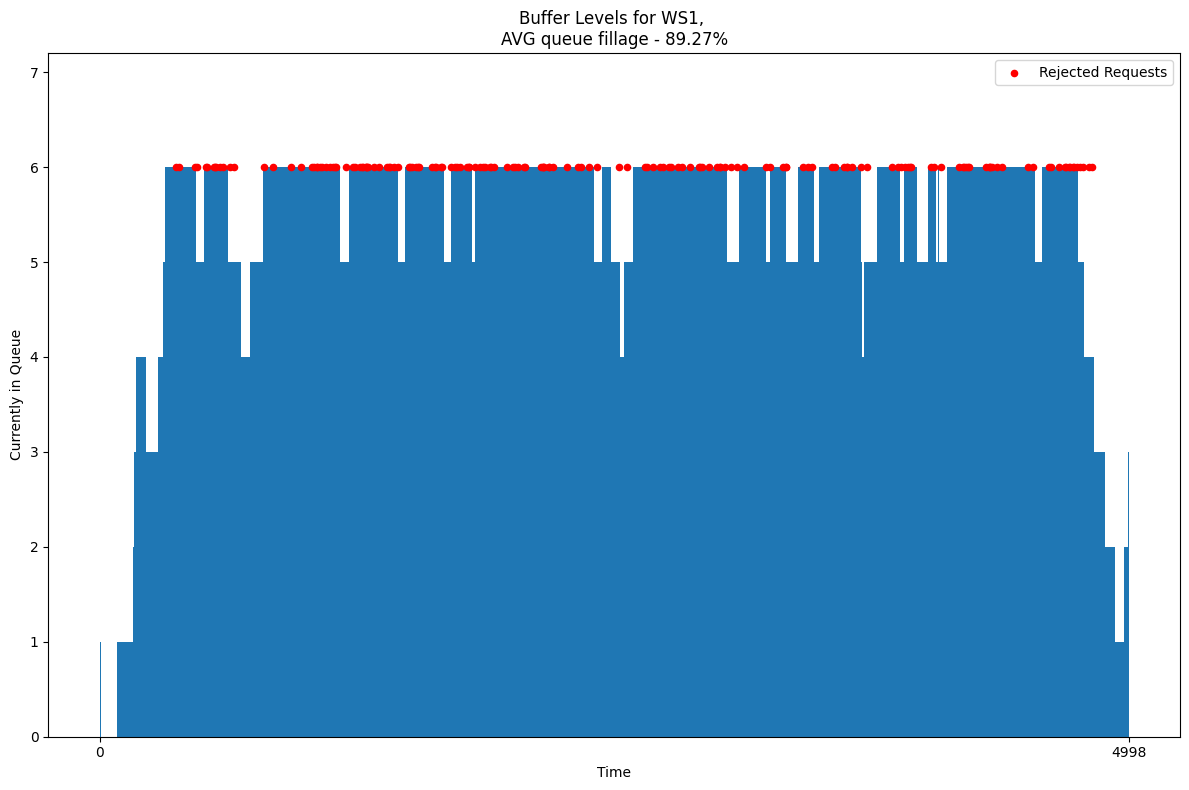

{'WS1': np.float64(89.27)}


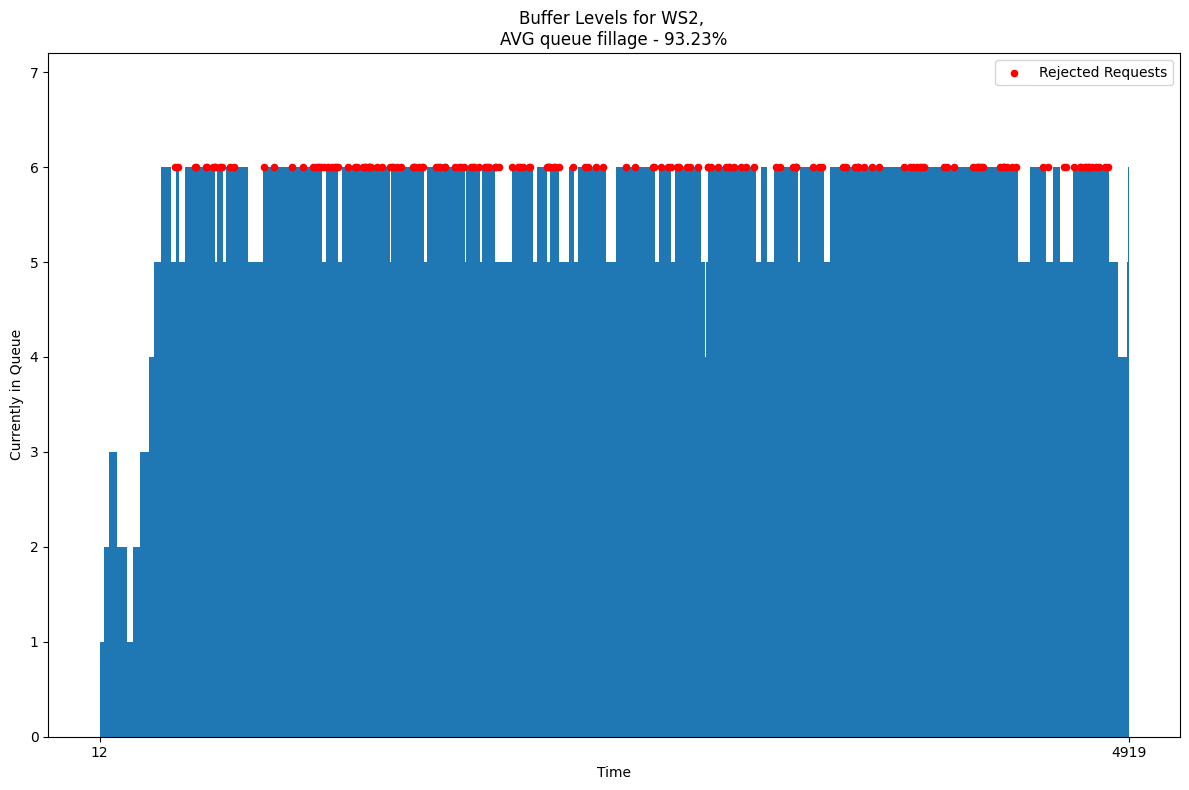

{'WS1': np.float64(89.27), 'WS2': np.float64(93.23)}


In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_buffer_levels(data_df, rejects, max_buffer,plot=True):

    # Get unique sources from the DataFrame
    unique_sources = data_df['source'].unique()
    avg_queues_p = {}
    # Iterate through each source to create the plots
    for source in unique_sources:
        temp_sum = 0
        df_a = data_df[data_df['source'] == source]
        for idx in range(df_a.shape[0]-1):
            temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
        avg_queue_p = np.round(temp_sum / df_a['ts_in_ms'].values[-1] / max_buffer *100,2)
        avg_queues_p[f'{source}'] = avg_queue_p
        # Filter the data for the current source
        source_data = data_df[data_df['source'] == source]
        if plot:
            # Create a new figure for each source
            plt.figure(figsize=(12, 8))
            
            # Step plot for currently in queue
            plt.step(source_data['ts_in_ms'], source_data['currently_in_queue'], where='mid', alpha=0)
            plt.fill_between(source_data['ts_in_ms'], source_data['currently_in_queue'], step='mid')

            # Set the limits for the y-axis
            plt.ylim(0, max_buffer*1.2)
            
            # Scatter plot for rejected requests
            plt.scatter(rejects['ts_in_ms'], np.ones(len(rejects)) * max_buffer, 
                        color='red', s=20, label='Rejected Requests')

            # Set title and labels
            plt.title(f'Buffer Levels for {source}, \nAVG queue fillage - {avg_queue_p}%')
            plt.xlabel('Time')
            plt.ylabel('Currently in Queue')
            plt.legend()
            
            # Set x-axis ticks
            plt.xticks([np.min(source_data['ts_in_ms']), np.max(source_data['ts_in_ms'])])
            
            # Show the plot
            plt.tight_layout()
            plt.show()
            print(avg_queues_p)
        else:
            return avg_queues_p
# Example usage
max_buffer = 6  # Set the maximum buffer level as needed
plot_buffer_levels(data_df, rejects, max_buffer)


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_96912/2618594404.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


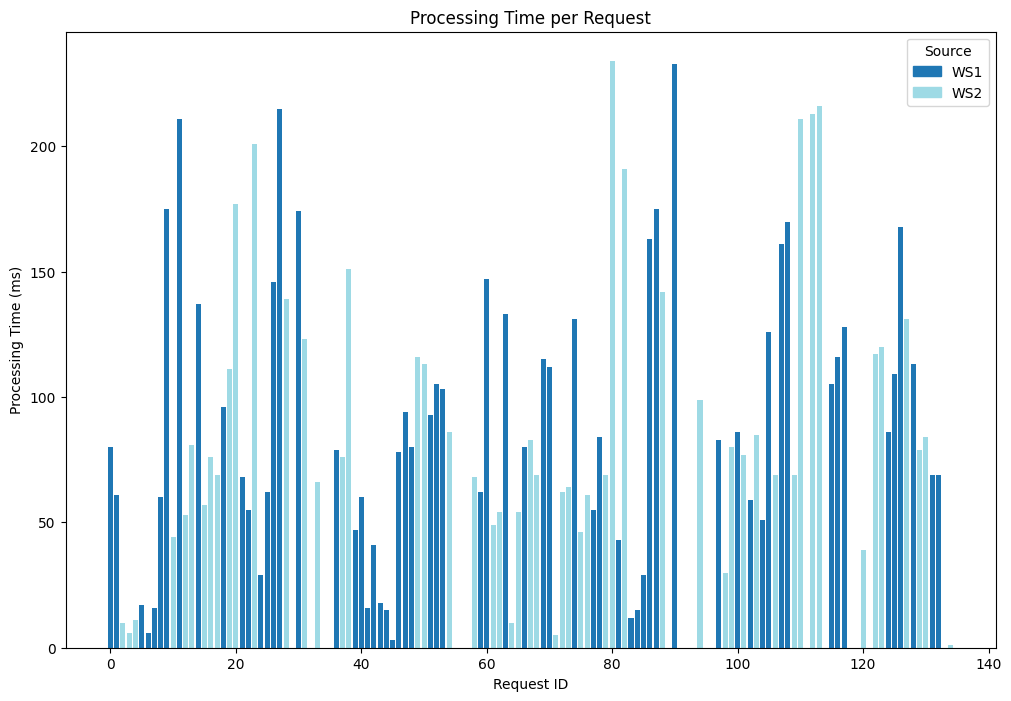

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_processing_times(merged_df, plot = True):
    unique_sources = merged_df['source_queued'].unique()
    avg_times = {}
    stds_times = {}
    for source in unique_sources:
        avg_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].mean()
        stds_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].std()
    avg_times['Global'] = result['processing_time_ms'].mean()
    stds_times['Global'] = result[result['source_queued']==source]['processing_time_ms'].std()
   
    if plot:
        num_sources = len(unique_sources)
        cmap = cm.get_cmap('tab20', num_sources)  
        color_mapping = {source: cmap(i) for i, source in enumerate(unique_sources)}

        colors = merged_df['source_queued'].map(color_mapping)
    
        fig = plt.figure(figsize=[12, 8])
        plt.bar(merged_df['request'], merged_df['processing_time_ms'], color=colors)

        plt.xlabel('Request ID')
        plt.ylabel('Processing Time (ms)')
        plt.title('Processing Time per Request')
        

        handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[source]) for source in unique_sources]
        plt.legend(handles, unique_sources, title="Source")
        plt.show()
    else:
        return avg_times, stds_times

plot_processing_times(result)

In [9]:
np.arange(0.01,0.21,0.02)

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19])

In [ ]:
reject_percent = {}
avg_times = {}
avg_times_stds = {}
avg_queues_p = {}
max_buffer = 5
times = np.arange(0.01,0.21,0.01)
# times = [0.02,0.03,0.04,0.06]
for start in ['shortest_queue','random']:
    for process_time in times:
        sim = await simulation_cli(num_servers=2,server_buffer_size=max_buffer,server_mu=process_time,lambda_=50,simulation_time=15,routing_fn=start, logging=False)
        reject_percent[f'{start}_{process_time}'] = sim.get('total_rejected')/(sim.get('total_processed')+sim.get('total_rejected'))
        file_path = f'.logs/route_{start}_0.json'
        data_df, result, rejects = process_queue_data(file_path)
        avg_times[f'{start}_{process_time}'],avg_times_stds[f'{start}_{process_time}'] =  plot_processing_times(result,plot=False)
        avg_queues_p[f'{start}_{process_time}'] =plot_buffer_levels(data_df, rejects, max_buffer+1,plot=False)
        


Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 695
Odrzucone zgłoszenia: 0
Zgłoszenia w kolejkach: 0

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 723
Odrzucone zgłoszenia: 0
Zgłoszenia w kolejkach: 0

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 690
Odrzucone zgłoszenia: 3
Zgłoszenia w kolejkach: 1

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 694
Odrzucone zgłoszenia: 30
Zgłoszenia w kolejkach: 0

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 574
Odrzucone zgłoszenia: 120
Zgłoszenia w kolejkach: 6

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 495
Odrzucone zgłoszenia: 212
Zgłoszenia w kolejkach: 6

Start symulacji - polityka route_s

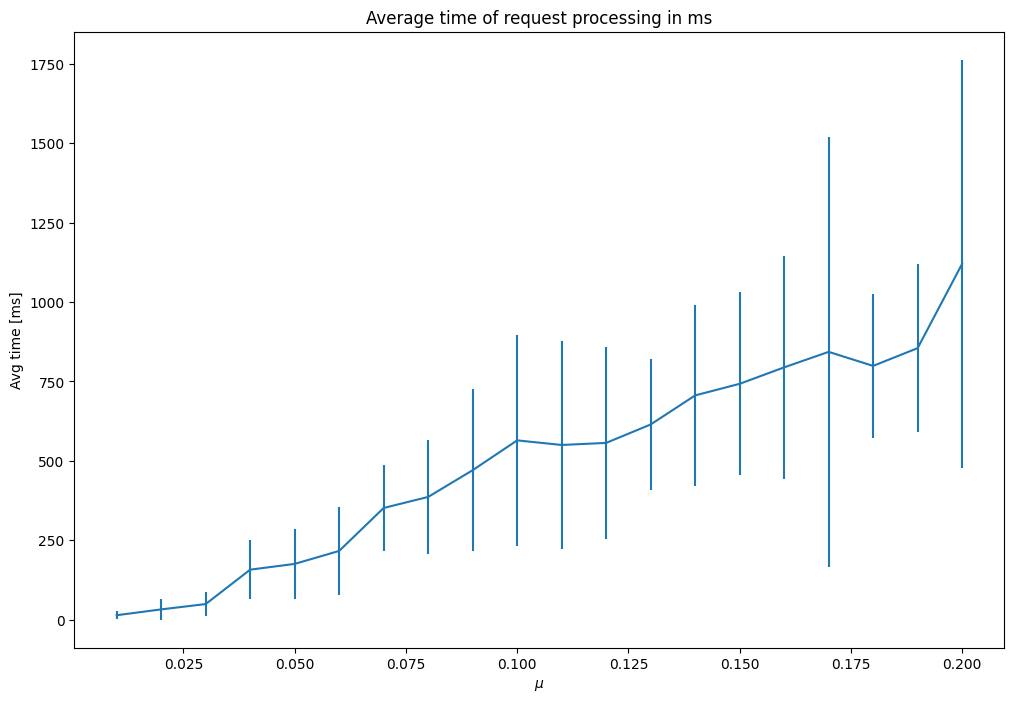

In [71]:
size = len(times)
shortest_dict = {key: val for key, val in avg_times.items() if key.startswith('short')}
shortest_dict_yerr = {key: val for key, val in avg_times_stds.items() if key.startswith('short')}

fig = plt.figure(figsize=[12,8])
plt.errorbar(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size),yerr=pd.DataFrame.from_dict(shortest_dict_yerr)[-1:].values.reshape(size))
plt.title('Average time of request processing in ms')
plt.xlabel(r'$\mu$')
plt.ylabel('Avg time [ms]')
fig.savefig('plots/avg_req_time.jpg')

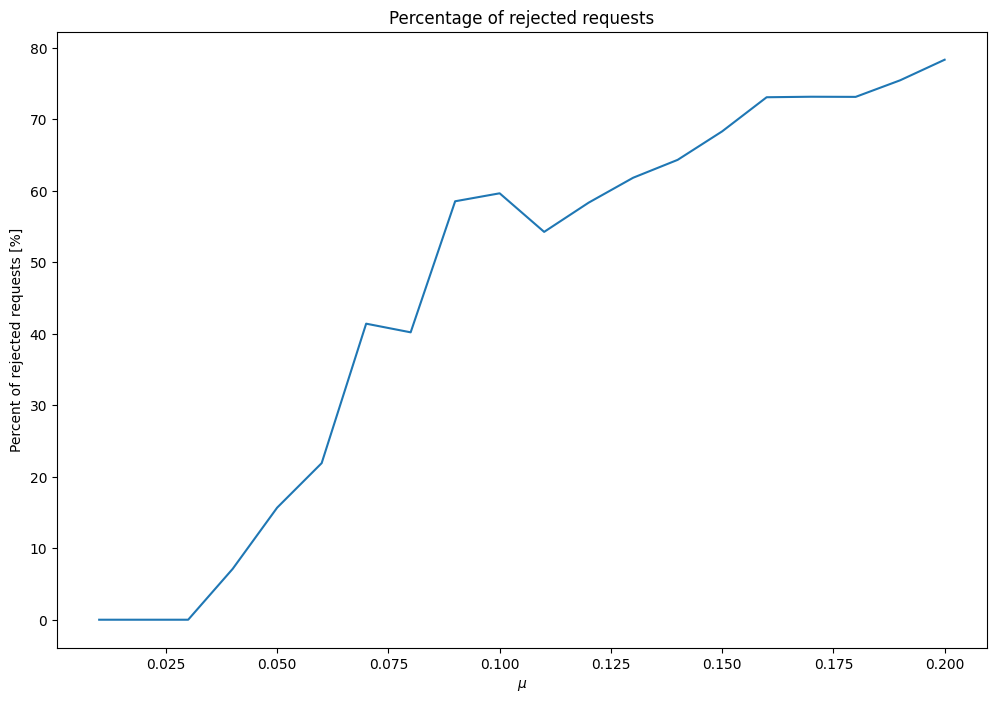

In [72]:
size = len(times)
shortest_dict = {key: val for key, val in reject_percent.items() if key.startswith('short')}
fig = plt.figure(figsize=[12,8])
plt.plot(times,np.array(list(shortest_dict.values()))*100)
plt.title('Percentage of rejected requests')
plt.xlabel(r'$\mu$')
plt.ylabel('Percent of rejected requests [%]')
fig.savefig('plots/rejected_req.jpg')

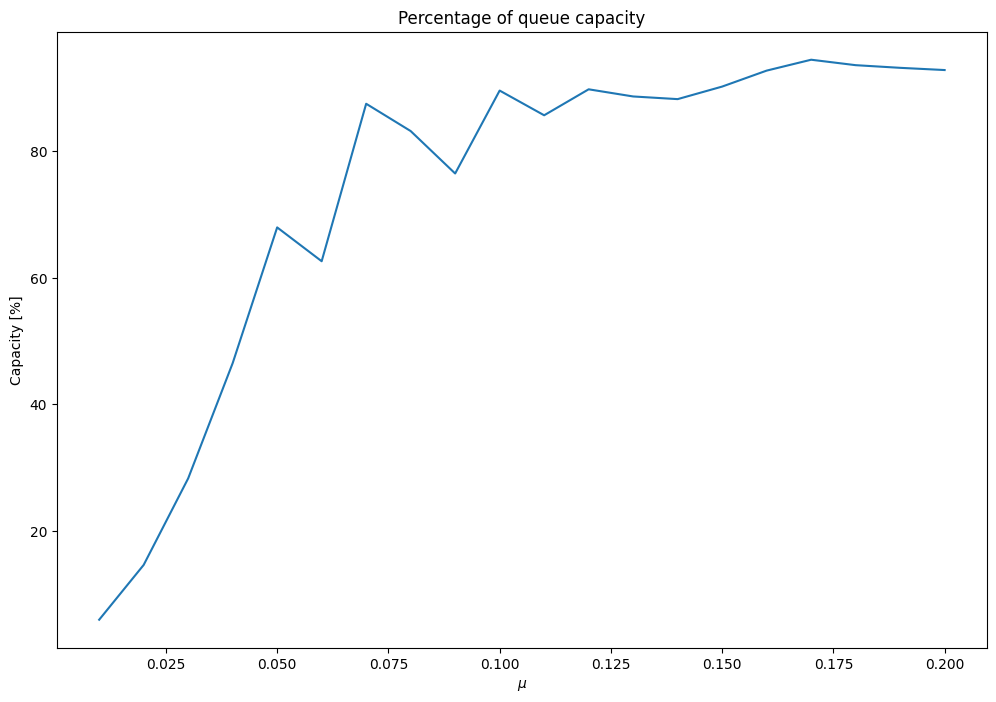

In [73]:
shortest_dict = {key: val for key, val in avg_queues_p.items() if key.startswith('random')}
fig = plt.figure(figsize=[12,8])
plt.plot(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size))
plt.title('Percentage of queue capacity')
plt.xlabel(r'$\mu$')
plt.ylabel('Capacity [%]')
fig.savefig('plots/rejected_time.jpg')